How to find the good interactions between features to use in the model

In [445]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

In [407]:
with open('forest-cover-type-prediction/train.csv', 'rt') as f:
    reader = csv.reader(f)
    header = next(reader)

In [408]:
my_data = np.genfromtxt('forest-cover-type-prediction/train.csv', delimiter=',')

In [409]:
data = my_data[1:, 1:my_data.shape[1]-1]  # avoid getting headers and ID column
labels = my_data[1:,-1]

In [410]:
# shuffle the training data
np.random.seed(0)

shuffle = np.random.permutation(np.arange(data.shape[0]))

shuffled_data = data[shuffle]
shuffled_labels = labels[shuffle]

# split the data to 60% train, 20% dev and 20% test
num_train = int(shuffled_data.shape[0]*0.6)
num_dev = int(shuffled_data.shape[0]*0.8)

train_data, train_labels = shuffled_data[:num_train], shuffled_labels[:num_train]
dev_data, dev_labels = shuffled_data[num_train:num_dev], shuffled_labels[num_train:num_dev]
test_data, test_labels = shuffled_data[num_dev:], shuffled_labels[num_dev:]

### Naive Bayes Considerations

1. How to deal with the continuous variables:
    * bucketing by percentiles
    * bucketing by int(np.log())
    * bucketing by fixed width buckets

In [290]:
def bucket_data_percentile(data, bucket):
    '''This function transform continuous data into discrete data by putting them into buckets of base on percentile'''

    lower_bound = np.min(data)
    bucketed_data = np.empty((data.shape[0],0))

    for i in range(1, bucket+1):
#         print(i, bucket)
        upper_bound = np.percentile(data, 100*i/bucket)
#         print(lower_bound, upper_bound)
        col = i * (data >= lower_bound) * (data < upper_bound)
        bucketed_data = np.hstack((bucketed_data,col.reshape(data.shape[0],1)))
        lower_bound = upper_bound

    output_data = np.sum(bucketed_data, axis=1)
#     print(output_data)

    return output_data.reshape(output_data.size,1)

In [305]:
def bucket_data_con_interval(data, bucket):
    '''This function transform continuous data into discrete data by putting them into buckets of constant intervals'''

    lower_bound = np.min(data)
    bucketed_data = np.empty((data.shape[0],0))

    for i in range(1, bucket+1):
        
        upper_bound = lower_bound+(np.max(data) - np.min(data))/bucket
        col = i * (data >= lower_bound) * (data < upper_bound)
        bucketed_data = np.hstack((bucketed_data,col.reshape(data.shape[0],1)))
        lower_bound = upper_bound

    output_data = np.sum(bucketed_data, axis=1)

    return output_data.reshape(output_data.size,1)

In [324]:
def bucket_data_log(data, bucket):
    return np.log(np.absolute(data)+1).astype('int').reshape(data.size,1)

In [327]:
def bucket_data(data, cols, bucket_method, bucket_num):
    transformed_data = np.empty((data.shape[0], 0))

    for i in range(data.shape[1]):
#         print(i)
        if i not in cols:
            transformed_data = np.hstack((transformed_data, data[:,i].reshape(data.shape[0],1)))
        else:
            transformed_data = np.hstack((transformed_data, bucket_method(data[:,i],bucket_num)))
    
    return transformed_data

In [411]:
# discrete_train_data = bucket_data(train_data, range(10), bucket_data_percentile, 7)
discrete_train_data = bucket_data(train_data, range(10), bucket_data_con_interval, 7)
# discrete_train_data = bucket_data(train_data, range(10), bucket_data_log, None)


mnb = MultinomialNB()
# mnb.fit(discrete_train_data, train_labels)

alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 20.0, 30.0]}

grid_search = GridSearchCV(mnb, alphas, cv=5)
    
# fit the data
grid_search.fit(discrete_train_data, train_labels)

# report the results 
print('The best alpha is:', grid_search.best_params_['alpha'])
print('-'*50)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     if params['alpha'] == 0 or params['alpha'] == grid_search.best_params_['alpha']:
    print('alpha =', '%s,' %params['alpha'], 'Accuracy = ', mean_score)

The best alpha is: 0.5
--------------------------------------------------
alpha = 0.0001, Accuracy =  0.6010802469135802
alpha = 0.001, Accuracy =  0.6010802469135802
alpha = 0.01, Accuracy =  0.6010802469135802
alpha = 0.1, Accuracy =  0.6010802469135802
alpha = 0.5, Accuracy =  0.6014109347442681
alpha = 1.0, Accuracy =  0.6014109347442681
alpha = 2.0, Accuracy =  0.6009700176366843
alpha = 10.0, Accuracy =  0.6011904761904762
alpha = 20.0, Accuracy =  0.6005291005291006
alpha = 30.0, Accuracy =  0.5985449735449735


In [475]:
# Test the fit to predict on training data

discrete_train_data = bucket_data(train_data, range(10), bucket_data_con_interval, 7)
mnb = MultinomialNB()
mnb.fit(discrete_train_data, train_labels)

predictions = mnb.predict(discrete_train_data)

metrics.accuracy_score(train_labels, predictions)

0.609457671957672

* The classifier is underfitted

In [476]:
# Try to add the interaction of two features as a new feature

interactions = train_data[:,0] * train_data[:,5]
interactions = interactions.reshape(train_data.shape[0],1)
expanded_train_data = np.hstack((train_data, interactions))
# print(interactions)

In [478]:
# test fit

indices = [i for i in range(10)] + [expanded_train_data.shape[1]-1]
# print(indices)
discrete_train_data = bucket_data(expanded_train_data, indices, bucket_data_percentile, 7)

# print(discrete_train_data[:, -1])

mnb = MultinomialNB()
mnb.fit(discrete_train_data, train_labels)

predictions = mnb.predict(discrete_train_data)

metrics.accuracy_score(train_labels, predictions)

0.6138668430335097

(array([   0.,    0.,    0.,    0.,    0., 9072.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

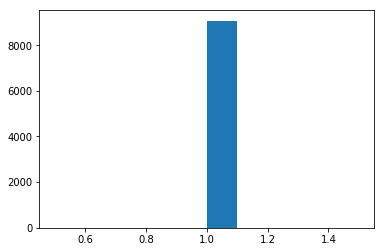

In [479]:
soil_sum = np.sum(train_data[:, 14:], axis = 1)

plt.hist(soil_sum)

* Only one soil is one per example